In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import prepare

import sys
sys.path.insert(0, 'User_Files')
import MVP_Davila, MVP_Shi

from tqdm import tqdm

## Iteration for MVP

### Acquire the train.csv containig the records of the randomly selected 2000 users

In [10]:
# Load the csv files containing all users
train = pd.read_csv("train.csv")

# Inspect the shapes
train.shape

(411517, 18)

In [3]:
# Print out the first 5 records
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [4]:
# Summarize the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


**Takeaways**
- The all-users dataset has more than 100 millions records. I only need a small sample to explore the whole data science pipeline
- **I will take the first 1000 user ids.**

### Subtract the records of the first 1000 users

In [20]:
# Define a function to subtract the first n users from the all-users train dataset

def sample_train(df, n):
    '''
    Accept the train.csv and an positive integer n
    and return the records of the first n users
    '''
    user_ids = df.user_id.value_counts().sort_index().iloc[0: n]
    user_ids = user_ids.index.to_list()
    df = df.set_index("user_id")
    sample = df.loc[user_ids]
    return sample

**Takeaways**
- The memoery usage of the first 1000 users are only 23 MB
- Missing values are found in columns:
    - prior_question_elapsed_time: 6670 nulls
    - prior_question_had_explanantion: 998 nulls

### Handling the null values in the below columns:
- prior_question_elapsed_time
- prior_question_had_explanantion

In [21]:
# The values of the two prior columns will always be 0 
# when the user first interacted with the system
# take a first user 115 for example

train1000.loc[115].head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,NaN
115,1,56943,5716,0,2,2,1,37000.0,False
115,2,118363,128,0,0,0,1,55000.0,False
115,3,131167,7860,0,3,0,1,19000.0,False
115,4,137965,7922,0,4,1,1,11000.0,False


**Takeawasy**
- There are only 1000 users so the two prior columns should have at leat 1000 nulls.
- The prior_question_had_explanantion column has 998 nulls:
    - fill the nulls with False
- I will further explore the missing values in the column prior_question_elapased_time.

### Fill the nulls in the prior_question_had_explanation with False

In [22]:
# Fill the nulls with False
train1000.prior_question_had_explanation.fillna(False, inplace = True)
train1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296615 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          296615 non-null  int64  
 1   timestamp                       296615 non-null  int64  
 2   content_id                      296615 non-null  int64  
 3   content_type_id                 296615 non-null  int64  
 4   task_container_id               296615 non-null  int64  
 5   user_answer                     296615 non-null  int64  
 6   answered_correctly              296615 non-null  int64  
 7   prior_question_elapsed_time     289945 non-null  float64
 8   prior_question_had_explanation  296615 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 30.6 MB


In [23]:
# Count the booleans values
train1000.prior_question_had_explanation.value_counts()

True     267494
False     29121
Name: prior_question_had_explanation, dtype: int64

### Fill the nulls in the prior_question_elapsed_time with string 0

In [24]:
# Print out all the records with missing values
# in the column prior_question_elapsed_time

mask = train1000.prior_question_elapsed_time.isnull()
train1000[mask]

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,NaN,False
124,46,0,7900,0,0,0,1,NaN,False
2746,76,0,5273,0,0,1,0,NaN,False
2746,89,653762,6808,1,14,-1,-1,NaN,False
5382,96,0,5000,0,0,0,1,NaN,False
...,...,...,...,...,...,...,...,...,...
5566848,296498,162115714,32168,1,21,-1,-1,NaN,False
5568049,296509,0,6028,0,0,3,0,NaN,False
5568049,296537,7746409318,24250,1,20,-1,-1,NaN,False


**Takeaways**
- When the user studies the lecture, the prior_question_elapsed_time documented as NaN.
- I will fill the missing values in the column prior_question_elapsed_time with 0.

In [25]:
# Fill the missing values in the column prior_question_elapsed_time with 0

train1000.prior_question_elapsed_time.fillna(0, inplace = True)
train1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296615 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          296615 non-null  int64  
 1   timestamp                       296615 non-null  int64  
 2   content_id                      296615 non-null  int64  
 3   content_type_id                 296615 non-null  int64  
 4   task_container_id               296615 non-null  int64  
 5   user_answer                     296615 non-null  int64  
 6   answered_correctly              296615 non-null  int64  
 7   prior_question_elapsed_time     296615 non-null  float64
 8   prior_question_had_explanation  296615 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 30.6 MB


**Takeawasy**
- All the null values have been addressed in the dataset. 

### Split the train1000 into train and test
- No validate dataset is created because the main purpose of the 1st iteration is to test the dataset pipeline.

In [37]:
# Generate the list of user ids
user_ids1000 = train1000.groupby(train1000.index).row_id.count().index.to_list()

# Create the empty train and test dataframe
train = pd.DataFrame()
test = pd.DataFrame()

# Set up the train size
train_size = 0.8

# Create a for loop to split the each user's record into train and test
# and then merge all the users into train and test
for user_id in user_ids1000:
    if train1000.loc[[user_id]].shape[0] <=2:
        print(user_id)
        continue
    elif train1000.loc[[user_id]].shape[0] > 2: 
        df = train1000.loc[[user_id]]
        n = df.shape[0]
        test_start_index = round(train_size * n)
        df_train = df.iloc[:test_start_index]
        df_test = df.iloc[test_start_index:]     
        train = pd.concat([train, df_train])
        test = pd.concat([test, df_test])
    
# Print the shape of the original dataset, the train and test
train1000.shape, train.shape, test.shape

1880240
2148001


((296615, 9), (237322, 9), (59290, 9))

**Takeaways**
- Such splitting methods will pose a potential problem: the questions that the students get in the test dataset are new and they are not in train. 

In [38]:
# Quickly check on the first two rows of the train
train.head(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,0,0,5692,0,1,3,1,0.0,False
115,1,56943,5716,0,2,2,1,37000.0,False


In [39]:
# Quickly check on the first two rows of the test
test.head(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
115,37,1415188,7882,0,37,2,1,20000.0,True
115,38,1468285,7962,0,38,3,1,17000.0,True


In [40]:
# Quickly check on the last two rows of the train
train.tail(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
5577726,296611,625327721,4303,0,8,3,0,10000.0,True
5577726,296612,625344560,4445,0,9,0,1,6000.0,True


In [41]:
# Quickly check on the last two rows of the test
test.tail(2)

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,,
5577726,296613,625367161,5206,0,10,1,0,6000.0,True
5577726,296614,625378759,3928,0,11,0,0,13000.0,True


In [42]:
# Quick summarize the train
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237322 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          237322 non-null  int64  
 1   timestamp                       237322 non-null  int64  
 2   content_id                      237322 non-null  int64  
 3   content_type_id                 237322 non-null  int64  
 4   task_container_id               237322 non-null  int64  
 5   user_answer                     237322 non-null  int64  
 6   answered_correctly              237322 non-null  int64  
 7   prior_question_elapsed_time     237322 non-null  float64
 8   prior_question_had_explanation  237322 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 16.5 MB


In [43]:
# Quick summarize the test
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59290 entries, 115 to 5577726
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   row_id                          59290 non-null  int64  
 1   timestamp                       59290 non-null  int64  
 2   content_id                      59290 non-null  int64  
 3   content_type_id                 59290 non-null  int64  
 4   task_container_id               59290 non-null  int64  
 5   user_answer                     59290 non-null  int64  
 6   answered_correctly              59290 non-null  int64  
 7   prior_question_elapsed_time     59290 non-null  float64
 8   prior_question_had_explanation  59290 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 4.1 MB


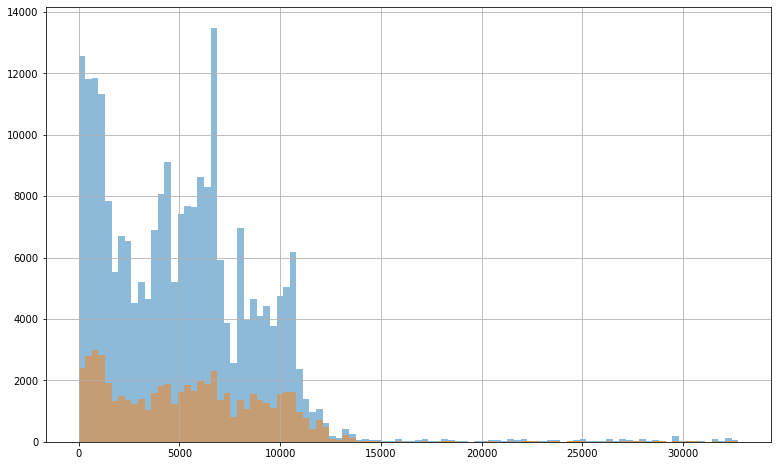

In [133]:
# To Compare the distribution of content_id in train and test

plt.figure(figsize=(13, 8))
train.content_id.hist(bins=100, alpha=0.5)
test.content_id.hist(bins=100, alpha=0.5)

plt.show()

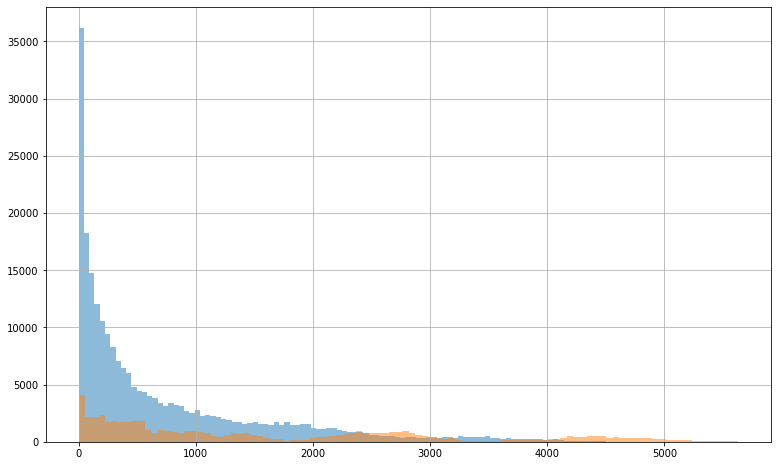

In [134]:
# To Compare the distribution of task_container_id in train and test

plt.figure(figsize=(13, 8))
train.task_container_id.hist(bins=100, alpha=0.5)
test.task_container_id.hist(bins=100, alpha=0.5)

plt.show()

### Count how many lectures each user has reviewed in the train

In [44]:
# Create a new columns for if the student review the lecture or not

train['reviewed_lecture'] = (train['answered_correctly'] == -1)
train.head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,reviewed_lecture
user_id,,,,,,,,,,
115,0,0,5692,0,1,3,1,0.0,False,False
115,1,56943,5716,0,2,2,1,37000.0,False,False
115,2,118363,128,0,0,0,1,55000.0,False,False
115,3,131167,7860,0,3,0,1,19000.0,False,False
115,4,137965,7922,0,4,1,1,11000.0,False,False


In [45]:
# Compute how many times each user reviewed the lecture

count_reviewed_lecture_train = train.groupby(train.index).reviewed_lecture.sum()
count_reviewed_lecture_train

user_id
115        0
124        0
2746       1
5382       1
8623       2
          ..
5555086    0
5566848    2
5568049    1
5571864    0
5577726    0
Name: reviewed_lecture, Length: 998, dtype: int64

In [46]:
# Merge the new feature with test dataset
test = test.merge(count_reviewed_lecture_train, how="left", on='user_id')

# Print the first 5 rows with new features
test.head()

,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,reviewed_lecture
user_id,,,,,,,,,,
115,37,1415188,7882,0,37,2,1,20000.0,True,0
115,38,1468285,7962,0,38,3,1,17000.0,True,0
115,39,667861680,1278,0,39,3,1,21000.0,False,0
115,40,667971812,2065,0,40,2,1,17000.0,False,0
115,41,667971812,2064,0,40,1,1,17000.0,False,0


**Takeaways**
- The user didn't review the lecture in the train dataset but reference the lecture in the test dataset.
- It is relative complicated in codes, so just drop the column for now.

In [47]:
# Drop the reviewed_lecture column in train and test
# Since Samuel is going to create the features

train.drop(columns='reviewed_lecture', inplace=True)
test.drop(columns='reviewed_lecture', inplace=True)

In [48]:
# Print the shapes
train.shape, test.shape

((237322, 9), (59290, 9))

### Drop the lecture rows in train and test

In [49]:
# Drop the lecture rows in train
mask = train['answered_correctly'] != -1
train = train[mask]

# Print the shape
train.shape

(232718, 9)

**Quick note**: the number of observations in the train drops from 237322 to 232718

In [50]:
# Drop the lecture rows in test
mask = test['answered_correctly'] != -1
test = test[mask]

# Print the shape
test.shape

(58222, 9)

**Quick note**: the number of observations in the test drops from 59290 to 58222.

In [51]:
# Reset the index in the train and test for the purpose of later merge
train.reset_index(inplace=True)
train.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,0,0,5692,0,1,3,1,0.0,False
1,115,1,56943,5716,0,2,2,1,37000.0,False
2,115,2,118363,128,0,0,0,1,55000.0,False
3,115,3,131167,7860,0,3,0,1,19000.0,False
4,115,4,137965,7922,0,4,1,1,11000.0,False


In [52]:
# Reset the index in the train and test for the purpose of later merge
test.reset_index(inplace=True)
test.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,37,1415188,7882,0,37,2,1,20000.0,True
1,115,38,1468285,7962,0,38,3,1,17000.0,True
2,115,39,667861680,1278,0,39,3,1,21000.0,False
3,115,40,667971812,2065,0,40,2,1,17000.0,False
4,115,41,667971812,2064,0,40,1,1,17000.0,False


### Feature engineering - To measure the statistics of the whole content
- content_id
- task_container_id

In [67]:
# Compute the statistics of the content by the the content_id

content_stats = train.groupby('content_id').answered_correctly.agg(['mean', 
                                                                    'count', 
                                                                    'std', 
                                                                    'median', 
                                                                    'skew'])


# Rename the name of the columns

content_stats.columns = ['mean_content_accuracy', 
                         'total_questions_asked', 
                         'std_content_accuracy', 
                         'median_content_accuracy', 
                         'skew_content_accuracy']

# Print the first 5 rows in the stats
content_stats.head()

,mean_content_accuracy,total_questions_asked,std_content_accuracy,median_content_accuracy,skew_content_accuracy
content_id,,,,,
0,0.944444,18,0.235702,1.0,-4.242641
1,0.928571,14,0.267261,1.0,-3.741657
2,0.566372,113,0.497783,1.0,-0.271474
3,0.793103,58,0.408619,1.0,-1.485842
4,0.480519,77,0.502897,0.0,0.079539


In [68]:
# Compute the statistics of the content by the the task_container_id

task_container_stats = train.groupby('task_container_id').answered_correctly.agg(['mean', 
                                                                                  'count', 
                                                                                  'std', 
                                                                                  'median', 
                                                                                  'skew'])


# Rename the name of the columns

task_container_stats.columns = ['mean_task_accuracy', 
                                'total_questions_asked', 
                                'std_task_accuracy', 
                                'median_task_accuracy', 
                                'skew_task_accuracy']

# Print the first 5 rows of the statistics
task_container_stats.head()

,mean_task_accuracy,total_questions_asked,std_task_accuracy,median_task_accuracy,skew_task_accuracy
task_container_id,,,,,
0,0.696215,1004,0.460120,1.0,-0.854589
1,0.522908,1004,0.499724,1.0,-0.091867
2,0.429429,999,0.495243,0.0,0.285566
3,0.543912,1002,0.498317,1.0,-0.176595
4,0.493096,1738,0.500096,0.0,0.027644


### Feature Engineering: To measure the historical performance of each user
- mean user accuracy
- mean time to answer the question
- mean time to answer the prior question
- convert the column 'prior question had been explained nor not' to bool

In [69]:
# Take a peek at the train
train.head()

,user_id,row_id,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,0,0,5692,0,1,3,1,0.0,False
1,115,1,56943,5716,0,2,2,1,37000.0,False
2,115,2,118363,128,0,0,0,1,55000.0,False
3,115,3,131167,7860,0,3,0,1,19000.0,False
4,115,4,137965,7922,0,4,1,1,11000.0,False


In [63]:
# Compute the statistics of the correctness of
# the answers from each user

user_answer_stats = train.groupby("user_id").answered_correctly.agg(['mean', 
                                                                      'count', 
                                                                      'std', 
                                                                      'median', 
                                                                      'skew'])


# Rename the name of the columns

user_answer_stats.columns = ['mean_user_accuracy', 
                            'total_questions_asked', 
                            'std_user_accuracy', 
                            'median_user_accuracy', 
                            'skew_user_accuracy']

# Take a look at the stats
user_answer_stats.head()

,mean_user_accuracy,total_questions_asked,std_user_accuracy,median_user_accuracy,skew_user_accuracy
user_id,,,,,
115,0.702703,37,0.463373,1.0,-0.924895
124,0.291667,24,0.464306,0.0,0.978979
2746,0.533333,15,0.516398,1.0,-0.148961
5382,0.693069,101,0.463521,1.0,-0.849885
8623,0.602273,88,0.492233,1.0,-0.425210


In [58]:
# Compute the statistics of 
# the average time every user spent on the system

timestamp_stats = train.groupby("user_id").timestamp.agg(['mean', 
                                                          'count', 
                                                          'std', 
                                                          'median', 
                                                          'skew'])


# Rename the name of the columns

timestamp_stats.columns = ['mean_usertime', 
                           'total_questions_asked', 
                           'std_usertime', 
                           'median_usertime', 
                           'skew_usertime']

# Take a look at the dataframe
timestamp_stats.head()

,mean_usertime,question_asked,std_usertime,median_usertime,skew_usertime
user_id,,,,,
115,5.083378e+05,37,3.687448e+05,437272.0,1.072164
124,3.183957e+05,24,1.681192e+05,330528.0,-0.370039
2746,2.584739e+05,15,2.233817e+05,234605.0,0.834430
5382,2.276186e+08,101,1.609300e+08,299355642.0,-0.415909
8623,2.569741e+08,88,1.640725e+08,320281387.0,-0.009533


In [64]:
# Compute the statistics of prior question elapsed time used by each user

priortime_stats = train.groupby("user_id").prior_question_elapsed_time.agg(['mean', 
                                                                            'count', 
                                                                            'std', 
                                                                            'median', 
                                                                            'skew'])


# Rename the name of the columns

priortime_stats.columns = ['mean_priortime', 
                           'total_questions_asked', 
                           'std_priortime', 
                           'median_priortime', 
                           'skew_priortime']

# Take a look at the dataframe
priortime_stats.head()

,mean_priortime,total_questions_asked,std_priortime,median_priortime,skew_priortime
user_id,,,,,
115,20135.135135,37,8310.509284,20000.0,1.796349
124,21041.541667,24,8581.065906,21333.0,-0.579390
2746,16866.666667,15,6104.643042,17000.0,-1.124964
5382,36910.891089,101,28382.071457,25000.0,2.471402
8623,27995.454545,88,19703.946212,21000.0,1.650412


### Merge the new features with the train and test one by one

In [88]:
# Check point: copy the train and test dataframe
df_train = train.copy()
df_test = test.copy()

# Print the shapes
df_train.shape, df_test.shape

((232718, 10), (58222, 10))

#### Merge the train and test with the mean of the content accuracy

In [89]:
# Merge with mean of the content accuracy
df_train = df_train.merge(content_stats[['mean_content_accuracy']], how='left', on='content_id')

# Drop the content_id and content_type_id columns
df_train.drop(columns=['content_id', 'content_type_id'], inplace=True)

# Print the new train
df_train.head()

,user_id,row_id,timestamp,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy
0,115,0,0,1,3,1,0.0,False,0.702381
1,115,1,56943,2,2,1,37000.0,False,0.789474
2,115,2,118363,0,0,1,55000.0,False,0.979167
3,115,3,131167,3,0,1,19000.0,False,0.962963
4,115,4,137965,4,1,1,11000.0,False,0.977778


In [90]:
# Quick summarize the new train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232718 entries, 0 to 232717
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   content_id                      232718 non-null  int64  
 4   content_type_id                 232718 non-null  int64  
 5   task_container_id               232718 non-null  int64  
 6   user_answer                     232718 non-null  int64  
 7   answered_correctly              232718 non-null  int64  
 8   prior_question_elapsed_time     232718 non-null  float64
 9   prior_question_had_explanation  232718 non-null  bool   
dtypes: bool(1), float64(1), int64(8)
memory usage: 16.2 MB


In [91]:
# Merge with mean of the content accuracy
df_test = df_test.merge(content_stats[['mean_content_accuracy']], how='left', on='content_id')

# Drop the content_id and content_type_id columns
df_test.drop(columns=['content_id', 'content_type_id'], inplace=True)

# Print the new train
df_test.head()

,user_id,row_id,timestamp,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy
0,115,37,1415188,37,2,1,20000.0,True,0.928571
1,115,38,1468285,38,3,1,17000.0,True,1.000000
2,115,39,667861680,39,3,1,21000.0,False,0.668246
3,115,40,667971812,40,2,1,17000.0,False,0.655738
4,115,41,667971812,40,1,1,17000.0,False,0.625293


In [92]:
# Quick summarize the test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   task_container_id               58222 non-null  int64  
 4   user_answer                     58222 non-null  int64  
 5   answered_correctly              58222 non-null  int64  
 6   prior_question_elapsed_time     58222 non-null  float64
 7   prior_question_had_explanation  58222 non-null  bool   
 8   mean_content_accuracy           57904 non-null  float64
dtypes: bool(1), float64(2), int64(6)
memory usage: 4.1 MB


**Takeaways**
- Missing values in column mean_content_acccuray have been detected in the test dataset. 
- It is maybe caused by how the data has been split.
    - The data has been split based on the timestamp: the time they have been spent on the questions.
    - The content they are tested on will be chaning over time.
    - The content in the train dataset will be different from the content in the test dataset. 
- It is maybe cuased by such a small sample. 

In [93]:
# Merge with mean of the task container accuracy
df_train = df_train.merge(task_container_stats[['mean_task_accuracy']], how='left', on='task_container_id')

# Drop the content_id and content_type_id columns
df_train.drop(columns=['task_container_id'], inplace=True)

# Print the new train
df_train.head()

,user_id,row_id,timestamp,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy
0,115,0,0,3,1,0.0,False,0.702381,0.522908
1,115,1,56943,2,1,37000.0,False,0.789474,0.429429
2,115,2,118363,0,1,55000.0,False,0.979167,0.696215
3,115,3,131167,0,1,19000.0,False,0.962963,0.543912
4,115,4,137965,1,1,11000.0,False,0.977778,0.493096


In [94]:
# Quick summarize the new train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232718 entries, 0 to 232717
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   content_id                      232718 non-null  int64  
 4   content_type_id                 232718 non-null  int64  
 5   task_container_id               232718 non-null  int64  
 6   user_answer                     232718 non-null  int64  
 7   answered_correctly              232718 non-null  int64  
 8   prior_question_elapsed_time     232718 non-null  float64
 9   prior_question_had_explanation  232718 non-null  bool   
dtypes: bool(1), float64(1), int64(8)
memory usage: 16.2 MB


In [95]:
# Merge with mean of the task container accuracy
df_test = df_test.merge(task_container_stats[['mean_task_accuracy']], how='left', on='task_container_id')

# Drop the content_id and content_type_id columns
df_test.drop(columns=['task_container_id'], inplace=True)

# Print the new train
df_test.head()

,user_id,row_id,timestamp,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy
0,115,37,1415188,2,1,20000.0,True,0.928571,0.634454
1,115,38,1468285,3,1,17000.0,True,1.000000,0.631027
2,115,39,667861680,3,1,21000.0,False,0.668246,0.663830
3,115,40,667971812,2,1,17000.0,False,0.655738,0.691176
4,115,41,667971812,1,1,17000.0,False,0.625293,0.691176


In [96]:
# Quick summarize the test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   user_answer                     58222 non-null  int64  
 4   answered_correctly              58222 non-null  int64  
 5   prior_question_elapsed_time     58222 non-null  float64
 6   prior_question_had_explanation  58222 non-null  bool   
 7   mean_content_accuracy           57904 non-null  float64
 8   mean_task_accuracy              54268 non-null  float64
dtypes: bool(1), float64(3), int64(5)
memory usage: 4.1 MB


**Takeaways**
- Missing values have been detected in column mean_task_accuary
- The possible reasons have been discussed.
- For this quick run through, I will just fill the nulls with 0.5, which definitely will affect the final accuracy.

In [97]:
# Fill the null with 0.5

df_test.fillna(0.5, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   user_answer                     58222 non-null  int64  
 4   answered_correctly              58222 non-null  int64  
 5   prior_question_elapsed_time     58222 non-null  float64
 6   prior_question_had_explanation  58222 non-null  bool   
 7   mean_content_accuracy           58222 non-null  float64
 8   mean_task_accuracy              58222 non-null  float64
dtypes: bool(1), float64(3), int64(5)
memory usage: 4.1 MB


In [98]:
# Merge the mean_user_accuracy
df_train = df_train.merge(user_answer_stats[['mean_user_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_train.drop(columns="user_answer", inplace=True)

# Take a look at the new train
df_train.head()

,user_id,row_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy
0,115,0,0,1,0.0,False,0.702381,0.522908,0.702703
1,115,1,56943,1,37000.0,False,0.789474,0.429429,0.702703
2,115,2,118363,1,55000.0,False,0.979167,0.696215,0.702703
3,115,3,131167,1,19000.0,False,0.962963,0.543912,0.702703
4,115,4,137965,1,11000.0,False,0.977778,0.493096,0.702703


In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232718 entries, 0 to 232717
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   answered_correctly              232718 non-null  int64  
 4   prior_question_elapsed_time     232718 non-null  float64
 5   prior_question_had_explanation  232718 non-null  bool   
 6   mean_content_accuracy           232718 non-null  float64
 7   mean_task_accuracy              232718 non-null  float64
 8   mean_user_accuracy              232718 non-null  float64
dtypes: bool(1), float64(4), int64(4)
memory usage: 16.2 MB


In [100]:
# Merge the test with the mean_user_accuracy
df_test = df_test.merge(user_answer_stats[['mean_user_accuracy']], how="left", on="user_id")

# Drop the user_answer column
df_test.drop(columns="user_answer", inplace=True)

# Take a look at the new train
df_test.head()

,user_id,row_id,timestamp,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy
0,115,37,1415188,1,20000.0,True,0.928571,0.634454,0.702703
1,115,38,1468285,1,17000.0,True,1.000000,0.631027,0.702703
2,115,39,667861680,1,21000.0,False,0.668246,0.663830,0.702703
3,115,40,667971812,1,17000.0,False,0.655738,0.691176,0.702703
4,115,41,667971812,1,17000.0,False,0.625293,0.691176,0.702703


In [101]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   timestamp                       58222 non-null  int64  
 3   answered_correctly              58222 non-null  int64  
 4   prior_question_elapsed_time     58222 non-null  float64
 5   prior_question_had_explanation  58222 non-null  bool   
 6   mean_content_accuracy           58222 non-null  float64
 7   mean_task_accuracy              58222 non-null  float64
 8   mean_user_accuracy              58222 non-null  float64
dtypes: bool(1), float64(4), int64(4)
memory usage: 4.1 MB


In [102]:
# Merge the mean_timestamp_accuracy
df_train = df_train.merge(timestamp_stats[['mean_usertime']], how="left", on="user_id")

# Drop the user_answer column
df_train.drop(columns="timestamp", inplace=True)

# Take a look at the new train
df_train.head()

,user_id,row_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime
0,115,0,1,0.0,False,0.702381,0.522908,0.702703,508337.810811
1,115,1,1,37000.0,False,0.789474,0.429429,0.702703,508337.810811
2,115,2,1,55000.0,False,0.979167,0.696215,0.702703,508337.810811
3,115,3,1,19000.0,False,0.962963,0.543912,0.702703,508337.810811
4,115,4,1,11000.0,False,0.977778,0.493096,0.702703,508337.810811


In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232718 entries, 0 to 232717
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   answered_correctly              232718 non-null  int64  
 3   prior_question_elapsed_time     232718 non-null  float64
 4   prior_question_had_explanation  232718 non-null  bool   
 5   mean_content_accuracy           232718 non-null  float64
 6   mean_task_accuracy              232718 non-null  float64
 7   mean_user_accuracy              232718 non-null  float64
 8   mean_usertime                   232718 non-null  float64
dtypes: bool(1), float64(5), int64(3)
memory usage: 16.2 MB


In [105]:
# Merge the test with mean_timestamp_accuracy
df_test = df_test.merge(timestamp_stats[['mean_usertime']], how="left", on="user_id")

# Drop the user_answer column
df_test.drop(columns="timestamp", inplace=True)

# Take a look at the new train
df_test.head()

,user_id,row_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime
0,115,37,1,20000.0,True,0.928571,0.634454,0.702703,508337.810811
1,115,38,1,17000.0,True,1.000000,0.631027,0.702703,508337.810811
2,115,39,1,21000.0,False,0.668246,0.663830,0.702703,508337.810811
3,115,40,1,17000.0,False,0.655738,0.691176,0.702703,508337.810811
4,115,41,1,17000.0,False,0.625293,0.691176,0.702703,508337.810811


In [106]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   answered_correctly              58222 non-null  int64  
 3   prior_question_elapsed_time     58222 non-null  float64
 4   prior_question_had_explanation  58222 non-null  bool   
 5   mean_content_accuracy           58222 non-null  float64
 6   mean_task_accuracy              58222 non-null  float64
 7   mean_user_accuracy              58222 non-null  float64
 8   mean_usertime                   58222 non-null  float64
dtypes: bool(1), float64(5), int64(3)
memory usage: 4.1 MB


In [107]:
# Merge the mean_priortime_accuracy
df_train = df_train.merge(priortime_stats[['mean_priortime']], how="left", on="user_id")

# Drop the user_answer column
df_train.drop(columns="prior_question_elapsed_time", inplace=True)

# Take a look at the new train
df_train.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime,mean_priortime
0,115,0,1,False,0.702381,0.522908,0.702703,508337.810811,20135.135135
1,115,1,1,False,0.789474,0.429429,0.702703,508337.810811,20135.135135
2,115,2,1,False,0.979167,0.696215,0.702703,508337.810811,20135.135135
3,115,3,1,False,0.962963,0.543912,0.702703,508337.810811,20135.135135
4,115,4,1,False,0.977778,0.493096,0.702703,508337.810811,20135.135135


In [108]:
# Quick Summarize the new train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232718 entries, 0 to 232717
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         232718 non-null  int64  
 1   row_id                          232718 non-null  int64  
 2   timestamp                       232718 non-null  int64  
 3   content_id                      232718 non-null  int64  
 4   content_type_id                 232718 non-null  int64  
 5   task_container_id               232718 non-null  int64  
 6   user_answer                     232718 non-null  int64  
 7   answered_correctly              232718 non-null  int64  
 8   prior_question_elapsed_time     232718 non-null  float64
 9   prior_question_had_explanation  232718 non-null  bool   
dtypes: bool(1), float64(1), int64(8)
memory usage: 16.2 MB


In [109]:
# Merge the test with the mean_priortime_accuracy
df_test = df_test.merge(priortime_stats[['mean_priortime']], how="left", on="user_id")

# Drop the user_answer column
df_test.drop(columns="prior_question_elapsed_time", inplace=True)

# Take a look at the new train
df_test.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime,mean_priortime
0,115,37,1,True,0.928571,0.634454,0.702703,508337.810811,20135.135135
1,115,38,1,True,1.000000,0.631027,0.702703,508337.810811,20135.135135
2,115,39,1,False,0.668246,0.663830,0.702703,508337.810811,20135.135135
3,115,40,1,False,0.655738,0.691176,0.702703,508337.810811,20135.135135
4,115,41,1,False,0.625293,0.691176,0.702703,508337.810811,20135.135135


In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58222 entries, 0 to 58221
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         58222 non-null  int64  
 1   row_id                          58222 non-null  int64  
 2   answered_correctly              58222 non-null  int64  
 3   prior_question_had_explanation  58222 non-null  bool   
 4   mean_content_accuracy           58222 non-null  float64
 5   mean_task_accuracy              58222 non-null  float64
 6   mean_user_accuracy              58222 non-null  float64
 7   mean_usertime                   58222 non-null  float64
 8   mean_priortime                  58222 non-null  float64
dtypes: bool(1), float64(5), int64(3)
memory usage: 4.1 MB


In [111]:
df_train.describe()

,user_id,row_id,answered_correctly,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime,mean_priortime
count,2.327180e+05,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000,2.327180e+05,232718.000000
mean,2.969434e+06,148016.933787,0.671388,0.671388,0.671388,0.671388,6.187649e+09,25077.299259
std,1.601102e+06,85600.431882,0.469710,0.199005,0.090827,0.100709,7.751457e+09,6574.488484
min,1.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.177550e+04,956.521739
25%,1.567938e+06,73966.250000,0.000000,0.545455,0.636943,0.616089,9.943256e+08,20416.222622
50%,3.098296e+06,148110.500000,1.000000,0.687500,0.674157,0.688341,3.484819e+09,24314.534314
75%,4.357812e+06,222151.750000,1.000000,0.818182,0.714286,0.740778,8.144184e+09,27602.891749
max,5.577726e+06,296612.000000,1.000000,1.000000,1.000000,1.000000,6.217467e+10,71166.666667


**Takeaways**
1. Convert the the bool values to 0 and 1
2. Scale the columns between [0,1] by min-max scaler
    - mean_timestamp_accuracy
    - mean_priortime_accuracy

### Scaling the numeric variables by MinMax scaler

In [112]:
# Define the fucntion to MinMax scale the train dataset

def scale(train, test, columns_to_scale):
    
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(train[columns_to_scale])

    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    return scaler, train, test

In [114]:
# Scale the columns mean_timestamp_accuracy, mean_priortime_accuracy

columns_to_scale = ['mean_usertime', 'mean_priortime']
scaler, df_train_scaled, df_test_scaled = scale(df_train, df_test, columns_to_scale)

In [115]:
# Print the scaler and the shapes
scaler, df_train_scaled.shape, df_test_scaled.shape

(MinMaxScaler(), (232718, 11), (58222, 11))

In [116]:
# Take a look at the train
df_train_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime,mean_priortime,mean_usertime_scaled,mean_priortime_scaled
0,115,0,1,False,0.702381,0.522908,0.702703,508337.810811,20135.135135,0.000008,0.27316
1,115,1,1,False,0.789474,0.429429,0.702703,508337.810811,20135.135135,0.000008,0.27316
2,115,2,1,False,0.979167,0.696215,0.702703,508337.810811,20135.135135,0.000008,0.27316
3,115,3,1,False,0.962963,0.543912,0.702703,508337.810811,20135.135135,0.000008,0.27316
4,115,4,1,False,0.977778,0.493096,0.702703,508337.810811,20135.135135,0.000008,0.27316


In [117]:
# Take a look at the train
df_test_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime,mean_priortime,mean_usertime_scaled,mean_priortime_scaled
0,115,37,1,True,0.928571,0.634454,0.702703,508337.810811,20135.135135,0.000008,0.27316
1,115,38,1,True,1.000000,0.631027,0.702703,508337.810811,20135.135135,0.000008,0.27316
2,115,39,1,False,0.668246,0.663830,0.702703,508337.810811,20135.135135,0.000008,0.27316
3,115,40,1,False,0.655738,0.691176,0.702703,508337.810811,20135.135135,0.000008,0.27316
4,115,41,1,False,0.625293,0.691176,0.702703,508337.810811,20135.135135,0.000008,0.27316


In [118]:
# Drop the columns mean_timestamp_accuracy, mean_priortime_accuracy

df_train_scaled.drop(columns=['mean_usertime', 'mean_priortime'], inplace=True)
df_test_scaled.drop(columns=['mean_usertime', 'mean_priortime'], inplace=True)

# Print the shapes
df_train_scaled.shape, df_test_scaled.shape

((232718, 9), (58222, 9))

In [119]:
# Print the descriptive statistics of the train
df_train_scaled.describe()

,user_id,row_id,answered_correctly,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime_scaled,mean_priortime_scaled
count,2.327180e+05,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000,232718.000000
mean,2.969434e+06,148016.933787,0.671388,0.671388,0.671388,0.671388,0.099520,0.343551
std,1.601102e+06,85600.431882,0.469710,0.199005,0.090827,0.100709,0.124672,0.093640
min,1.150000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567938e+06,73966.250000,0.000000,0.545455,0.636943,0.616089,0.015992,0.277164
50%,3.098296e+06,148110.500000,1.000000,0.687500,0.674157,0.688341,0.056049,0.332687
75%,4.357812e+06,222151.750000,1.000000,0.818182,0.714286,0.740778,0.130989,0.379523
max,5.577726e+06,296612.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
# Print the descriptive statistics of the test
df_test_scaled.describe()

,user_id,row_id,answered_correctly,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime_scaled,mean_priortime_scaled
count,5.822200e+04,58222.000000,58222.000000,58222.000000,58222.000000,58222.000000,58222.000000,58222.000000
mean,2.968611e+06,149212.037168,0.681976,0.671215,0.688561,0.671571,0.099776,0.343512
std,1.602334e+06,85667.478363,0.465713,0.204805,0.142239,0.100382,0.124664,0.093677
min,1.150000e+02,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567938e+06,75246.250000,0.000000,0.536585,0.634615,0.616089,0.015992,0.277164
50%,3.098296e+06,148308.500000,1.000000,0.684932,0.685714,0.688341,0.056049,0.332687
75%,4.357812e+06,225132.750000,1.000000,0.820513,0.743243,0.740778,0.130989,0.379523
max,5.577726e+06,296614.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Conver the boolean columsn into 0 and 1

In [127]:
# Make a copy of the scaled train and test

train_scaled = df_train_scaled.copy()
test_scaled = df_test_scaled.copy()

In [128]:
# Take the value counts of prior_question_had_explanation in the scaled train dataset
train_scaled.prior_question_had_explanation.value_counts()

True     211394
False     21324
Name: prior_question_had_explanation, dtype: int64

In [129]:
# Conver the booleans values to 0 and 1

m = train_scaled.prior_question_had_explanation.apply(lambda i: 1 if i == True else 0)
train_scaled.prior_question_had_explanation = m
train_scaled.prior_question_had_explanation.value_counts()

1    211394
0     21324
Name: prior_question_had_explanation, dtype: int64

In [130]:
# Take the value counts of prior_question_had_explanation in scaled dataset
test_scaled.prior_question_had_explanation.value_counts()

True     56100
False     2122
Name: prior_question_had_explanation, dtype: int64

In [131]:
# Conver the booleans values to 0 and 1

m = test_scaled.prior_question_had_explanation.apply(lambda i: 1 if i == True else 0)
test_scaled.prior_question_had_explanation = m
test_scaled.prior_question_had_explanation.value_counts()

1    56100
0     2122
Name: prior_question_had_explanation, dtype: int64

In [132]:
# Inspect the train
train_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime_scaled,mean_priortime_scaled
0,115,0,1,0,0.702381,0.522908,0.702703,0.000008,0.27316
1,115,1,1,0,0.789474,0.429429,0.702703,0.000008,0.27316
2,115,2,1,0,0.979167,0.696215,0.702703,0.000008,0.27316
3,115,3,1,0,0.962963,0.543912,0.702703,0.000008,0.27316
4,115,4,1,0,0.977778,0.493096,0.702703,0.000008,0.27316


In [133]:
# Inspect the train
test_scaled.head()

,user_id,row_id,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime_scaled,mean_priortime_scaled
0,115,37,1,1,0.928571,0.634454,0.702703,0.000008,0.27316
1,115,38,1,1,1.000000,0.631027,0.702703,0.000008,0.27316
2,115,39,1,0,0.668246,0.663830,0.702703,0.000008,0.27316
3,115,40,1,0,0.655738,0.691176,0.702703,0.000008,0.27316
4,115,41,1,0,0.625293,0.691176,0.702703,0.000008,0.27316


### Drop the two id columns and the datasets are ready for modeling

In [134]:
# Drop the two id columns in the scaled train dataset
id_cols = ['user_id', 'row_id']
train_scaled.drop(columns=id_cols, inplace=True)

In [278]:
# Drop the two id columns in the scaled test dataset
test_scaled.drop(columns=id_cols, inplace=True)
test_scaled.head()

,answered_correctly,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_timestamp_accuracy_scaled,mean_priortime_accuracy_scaled
0,1,1,0.928571,0.634454,0.702703,0.000008,0.27316
1,1,1,1.000000,0.631027,0.702703,0.000008,0.27316
2,1,0,0.668246,0.663830,0.702703,0.000008,0.27316
3,1,0,0.655738,0.691176,0.702703,0.000008,0.27316
4,1,0,0.625293,0.691176,0.702703,0.000008,0.27316


### Seperate the features and target variables

In [135]:
X_train = train_scaled.drop(columns='answered_correctly')
y_train = train_scaled['answered_correctly']

X_test = test_scaled.drop(columns='answered_correctly')
y_test = test_scaled['answered_correctly']

In [136]:
# Inspect the X_train
X_train.head()

,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime_scaled,mean_priortime_scaled
0,0,0.702381,0.522908,0.702703,0.000008,0.27316
1,0,0.789474,0.429429,0.702703,0.000008,0.27316
2,0,0.979167,0.696215,0.702703,0.000008,0.27316
3,0,0.962963,0.543912,0.702703,0.000008,0.27316
4,0,0.977778,0.493096,0.702703,0.000008,0.27316


In [137]:
# Inspect y_train
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: answered_correctly, dtype: int64

In [138]:
# Inspect the X_test
X_test.head()

,user_id,row_id,prior_question_had_explanation,mean_content_accuracy,mean_task_accuracy,mean_user_accuracy,mean_usertime_scaled,mean_priortime_scaled
0,115,37,1,0.928571,0.634454,0.702703,0.000008,0.27316
1,115,38,1,1.000000,0.631027,0.702703,0.000008,0.27316
2,115,39,0,0.668246,0.663830,0.702703,0.000008,0.27316
3,115,40,0,0.655738,0.691176,0.702703,0.000008,0.27316
4,115,41,0,0.625293,0.691176,0.702703,0.000008,0.27316


In [139]:
# Inspect y_train
y_test.head()

0    1
1    1
2    1
3    1
4    1
Name: answered_correctly, dtype: int64

### Compute the baseline accuracy

In [141]:
y_train.value_counts(normalize=True)

1    0.671388
0    0.328612
Name: answered_correctly, dtype: float64

**Quick notes**: The baliseline accuracy is 0.67

### Model on train and test
- For the purpose of the quick running through, all the hypterparameters in the algorithms are set by default.

In [142]:
# Define the function that compute the performance metrics

def estimator_report(model_type, data_type, y_train, y_pred):
    matrix = confusion_matrix(y_train, y_pred)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    d = {'model_type': model_type, 'data_type': data_type, 
        'accuracy': accuracy, 'precision': precision, 'recall': recall}
    return d

In [293]:
# Create a list of names of the classifiers

names = ['LogisticRegression', 
         'Decision Tree',
         'Random Forest',
         'Ada Boost',
         'Gradient Boost',
         'Nearest Neighbors',
         'Naive Bays',
         'Neural Net',
         'Linear SVC'
        ]

In [294]:
# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3),
               RandomForestClassifier(max_depth=3),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               KNeighborsClassifier(3),
               GaussianNB(), 
               MLPClassifier(),
               SVC(kernel='linear')
              ]

In [295]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [298]:
metrics = pd.DataFrame()

for name, classifier in zip(names, classifiers):
    print(name)
    classifier = classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_train)
    d = estimator_report(name, 'train', y_train, y_pred)
    metrics = metrics.append(d, ignore_index=True)
    y_pred = classifier.predict(X_test)
    d = estimator_report(name, 'test', y_test, y_pred)
    metrics = metrics.append(d, ignore_index=True)

metrics # The whole process took about 30 mins

LogisticRegression
Decision Tree
Random Forest
Ada Boost
Gradient Boost
Nearest Neighbors
Naive Bays
Neural Net
Linear SVC


,accuracy,data_type,model_type,precision,recall
0,0.737884,train,LogisticRegression,0.760635,0.889513
1,0.702277,test,LogisticRegression,0.746779,0.852516
2,0.730910,train,Decision Tree,0.750984,0.896457
3,0.708220,test,Decision Tree,0.742362,0.876266
4,0.714440,train,Random Forest,0.719474,0.941937
5,0.702484,test,Random Forest,0.712259,0.945852
6,0.739681,train,Ada Boost,0.764086,0.885743
7,0.700165,test,Ada Boost,0.741119,0.861154
8,0.743217,train,Gradient Boost,0.769117,0.882434
9,0.699959,test,Gradient Boost,0.745241,0.850929


In [311]:
# Sor the metrics by accuracy
metrics.sort_values(by='accuracy', ascending=False)

,accuracy,data_type,model_type,precision,recall
10,0.830572,train,Nearest Neighbors,0.855976,0.898889
8,0.743217,train,Gradient Boost,0.769117,0.882434
14,0.741133,train,Neural Net,0.767402,0.881659
6,0.739681,train,Ada Boost,0.764086,0.885743
0,0.737884,train,LogisticRegression,0.760635,0.889513
16,0.737283,train,Linear SVC,0.752119,0.907926
2,0.730910,train,Decision Tree,0.750984,0.896457
4,0.714440,train,Random Forest,0.719474,0.941937
12,0.709851,train,Naive Bays,0.737793,0.880904
3,0.708220,test,Decision Tree,0.742362,0.876266


**Takeaways**
- Using the first 1000 users as a small sample, I am able to go thought the whole data science pipeline including data acquisition, preparation, quick exploraion and modeling.  
- The best model on test dataset gives 71% on accuarcy, which beat the baseline by 4%. 

## Iteration for Final Notebook

### Read the records of the randomly selected 2000 users

In [2]:
# Acquire the train, validate and test from csv files with 2000 user

df_train = pd.read_csv('train.csv')
df_validate = pd.read_csv('validate.csv')
df_test = pd.read_csv('test.csv')
df_ques = pd.read_csv('questions_with_tag_counts.csv', index_col=0)

# Print the shape of the datasets
df_train.shape, df_validate.shape, df_test.shape, df_ques.shape

((411517, 18), (50842, 18), (52868, 18), (13523, 6))

In [3]:
# Sanity check: to make sure all the dataset contains 2000 users
print("Total number of users in the train: ", df_train.user_id.nunique())
print("Total number of users in the validate: ", df_validate.user_id.nunique())
print("Total number of users in the test: ", df_test.user_id.nunique())

Total number of users in the train:  2000
Total number of users in the validate:  2000
Total number of users in the test:  2000


### To produce the  train/validate/test and the scaled train/validate/test

In [4]:
# Use the prep_riiid function in prepare.py to produce the datasets for exploration and modeling

train, validate, test, train_s, validate_s, test_s = prepare.prep_riiid(df_train, df_validate, df_test)

**Takeaways**
- The train dataset is going to be used for exploraion.
- The scaled train/validate/test datasets are going to be used for modeling. 

In [5]:
# Quickly inspect the columns of the train dataset
train.head(2)

,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,part,tags,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy
0,0,1864702,5720,0,1,False,0.630049,0,45951.0,11917302.0,...,5,115,1,0.82,0.61,1.0,0.82,0.68,0.62,0.79
1,45951,1864702,5204,1,0,False,0.630049,0,28391.0,11917302.0,...,5,173,1,0.55,0.61,0.0,0.55,0.53,0.62,0.65


In [6]:
# Print the summary of train
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403377 entries, 0 to 403376
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   timestamp                     403377 non-null  int64  
 1   user_id                       403377 non-null  int64  
 2   content_id                    403377 non-null  int64  
 3   task_container_id             403377 non-null  int64  
 4   answered_correctly            403377 non-null  int64  
 5   question_had_explanation      403376 non-null  object 
 6   user_acc_mean                 403377 non-null  float64
 7   user_lectures_running_total   403377 non-null  int64  
 8   q_time                        403377 non-null  float64
 9   avg_user_q_time               403377 non-null  float64
 10  question_id                   403377 non-null  int64  
 11  bundle_id                     403377 non-null  int64  
 12  part                          403377 non-nul

### Explorations

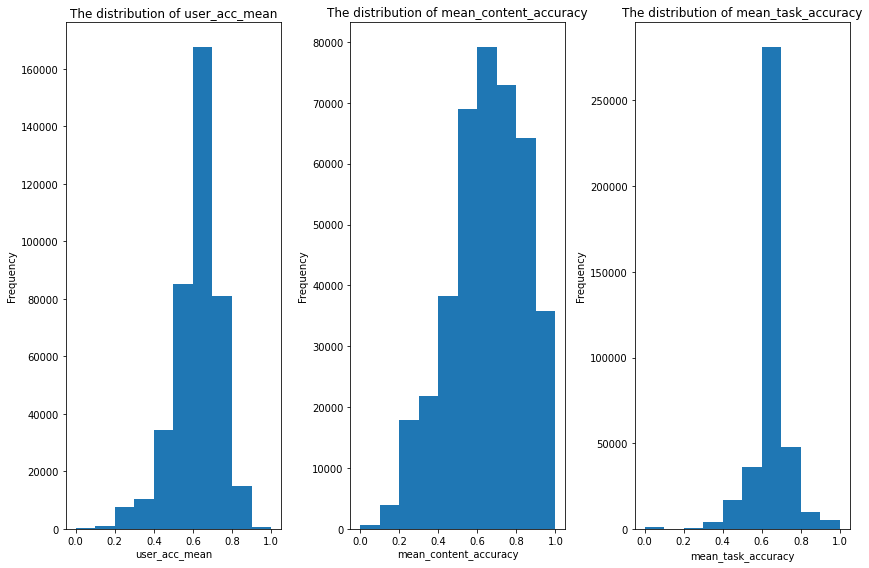

In [7]:
# Plot the distribution of the following features in the train: 
# user_acc_mean, mean_content_accuracy, mean_task_accuracy, mean_priortime_accuracy

cols = ["user_acc_mean", "mean_content_accuracy", "mean_task_accuracy"]

fig, axs = plt.subplots(1, 3, figsize=(12,8))

ax = axs.ravel()

for i, col in zip(range(4),cols):
    train[col].plot(kind="hist", ax=ax[i])
    ax[i].set_xlabel(col)
    ax[i].set_title(f"The distribution of {col}")
    
plt.tight_layout()

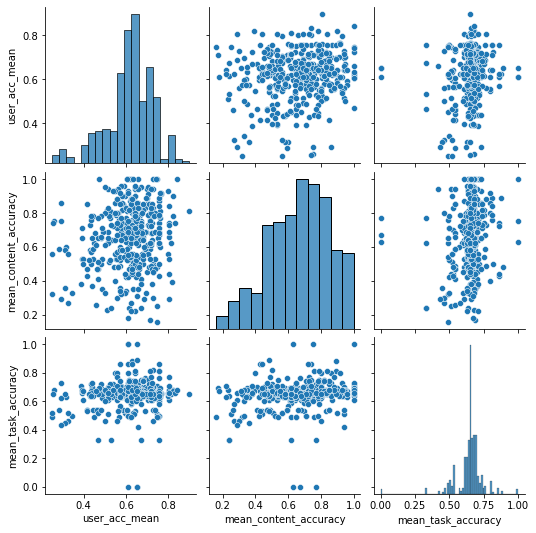

In [8]:
# Pairplot of the features below:
# user_acc_mean, mean_content_accuracy, mean_task_accuracy, mean_priortime_accuracy

cols = ["user_acc_mean", "mean_content_accuracy", "mean_task_accuracy"]
sample = train[cols].sample(frac=0.001, replace = False, random_state=123)
sns.pairplot(sample)
plt.show()

In [9]:
# Using the helper fucntion feature
# Count the number of users' interactions with the system over different time spans

user_id_on_time = explore.feature_over_time("user_id", df_train, "sum")
user_id_on_time.head()

NameError: name 'explore' is not defined

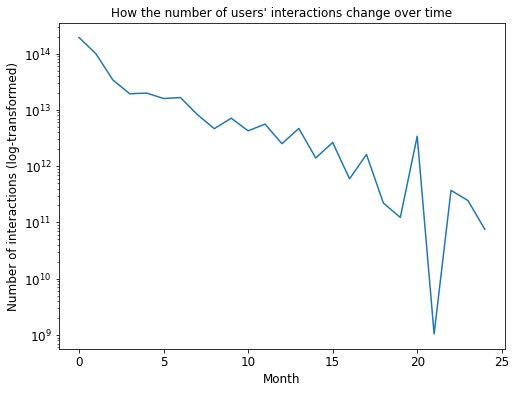

In [15]:
# Group the number of interactions by month, which is then plot again the months

user_id_on_time.groupby("months").user_id.sum().plot(figsize=(8, 6), logy=True, fontsize=12)
plt.title("How the number of users' interactions change over time", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of interactions (log-transformed)", fontsize=12)
plt.show()

In [16]:
# Compute the overall accuracy on answering questions over time

accuracy_on_time = explore.feature_over_time("answered_correctly", df_train, "mean")
accuracy_on_time.head()

,timestamp,answered_correctly,seconds,minutes,hours,days,months,years
0,0,0.683375,0.0,0.0,0.0,0.0,0.0,0.0
1,2323,1.000000,2.0,0.0,0.0,0.0,0.0,0.0
2,3376,0.000000,3.0,0.0,0.0,0.0,0.0,0.0
3,3774,0.000000,4.0,0.0,0.0,0.0,0.0,0.0
4,4181,0.000000,4.0,0.0,0.0,0.0,0.0,0.0


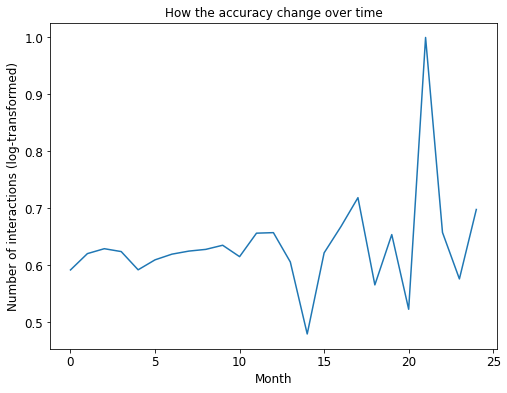

In [18]:
# Plot the overall accuracy over time

accuracy_on_time.groupby("months").answered_correctly.mean().plot(figsize=(8, 6), fontsize=12)
plt.title("How the accuracy change over time", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of interactions (log-transformed)", fontsize=12)
plt.show()

In [7]:
# Add column to specify whether a Part is reading or listening
# Add a column to specify whether a Pat is 'incomplete sentences' or not

train = train.assign(sections = np.where(train.part > 4, 'Reading', 'Listening'),
                     is_incomplete_sentence_part = np.where(train.part == 5, 'incomplete sentences', 'other'))

In [8]:
# Inspect if the columns have been successfully added
train.head(2)

,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,tag_count,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,sections,is_incomplete_sentence_part
0,0,1864702,5720,0,1,False,0.630049,0,45951.0,11917302.0,...,1,0.82,0.61,1.0,0.82,0.68,0.62,0.79,Reading,incomplete sentences
1,45951,1864702,5204,1,0,False,0.630049,0,28391.0,11917302.0,...,1,0.55,0.61,0.0,0.55,0.53,0.62,0.65,Reading,incomplete sentences


### Questions to answer: How do students perform in different part?

In [9]:
# Create a dataframe to hold the average acuracy for each part. 
part_acc = train.groupby('part').answered_correctly.mean()
part_acc = pd.DataFrame(part_acc).reset_index()
part_acc['Parts'] = ['Photographs', 'Question Response', "Conversations", 
                       "Talks", "Incomplete Sentences", "Text Completion", "Passages"]
part_acc = part_acc.sort_values(by='answered_correctly')
part_acc

,part,answered_correctly,Parts
4,5,0.610488,Incomplete Sentences
3,4,0.616874,Talks
5,6,0.652369,Text Completion
6,7,0.673089,Passages
2,3,0.679698,Conversations
1,2,0.697932,Question Response
0,1,0.740719,Photographs


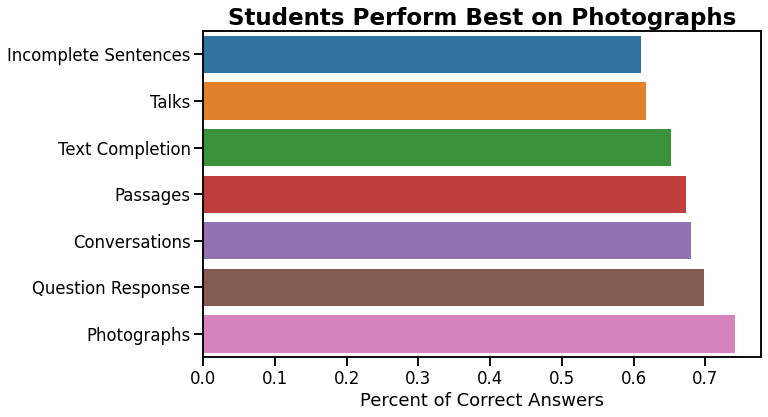

In [10]:
sns.set_context('talk')

plt.figure(figsize=(10, 6))
sns.barplot(data=part_acc, x='answered_correctly', y='Parts')
plt.xlabel("Percent of Correct Answers")
plt.ylabel("")
plt.title("Students Perform Best on Photographs", fontweight='bold', fontsize=23)
plt.show()

### Question to answer: How does the explanation affect the accuracy on different Parts?

In [11]:
part_explanation_acc = train.groupby(['part', 'question_had_explanation']).answered_correctly.mean()
part_explanation_acc.sort_values()

part  question_had_explanation
4     False                       0.417420
5     False                       0.447978
7     False                       0.570331
6     False                       0.576785
3     False                       0.581420
5     True                        0.627640
1     False                       0.640967
2     False                       0.652117
6     True                        0.660515
4     True                        0.674850
7     True                        0.688185
3     True                        0.690330
2     True                        0.700535
1     True                        0.760286
Name: answered_correctly, dtype: float64

In [12]:
part_explanation_acc = pd.DataFrame(part_explanation_acc).reset_index()
part_explanation_acc['part'] = part_explanation_acc.part.map({1: 'Photographs', 
                                                              2: 'Question Response', 
                                                              3: "Conversations", 
                                                              4: "Talks", 
                                                              5: "Incomplete Sentences", 
                                                              6: "Text Completion", 
                                                              7: "Passages"})
part_explanation_acc

,part,question_had_explanation,answered_correctly
0,Photographs,False,0.640967
1,Photographs,True,0.760286
2,Question Response,False,0.652117
3,Question Response,True,0.700535
4,Conversations,False,0.581420
5,Conversations,True,0.690330
6,Talks,False,0.417420
7,Talks,True,0.674850
8,Incomplete Sentences,False,0.447978
9,Incomplete Sentences,True,0.627640


In [13]:
part_explanation_acc['sorting'] = [1,1,2,2,3,3,5,5,7,7,6,6,4,4]
part_explanation_acc = part_explanation_acc.sort_values(by='sorting', ascending=False)
part_explanation_acc

,part,question_had_explanation,answered_correctly,sorting
8,Incomplete Sentences,False,0.447978,7
9,Incomplete Sentences,True,0.627640,7
10,Text Completion,False,0.576785,6
11,Text Completion,True,0.660515,6
6,Talks,False,0.417420,5
7,Talks,True,0.674850,5
12,Passages,False,0.570331,4
13,Passages,True,0.688185,4
4,Conversations,False,0.581420,3
5,Conversations,True,0.690330,3


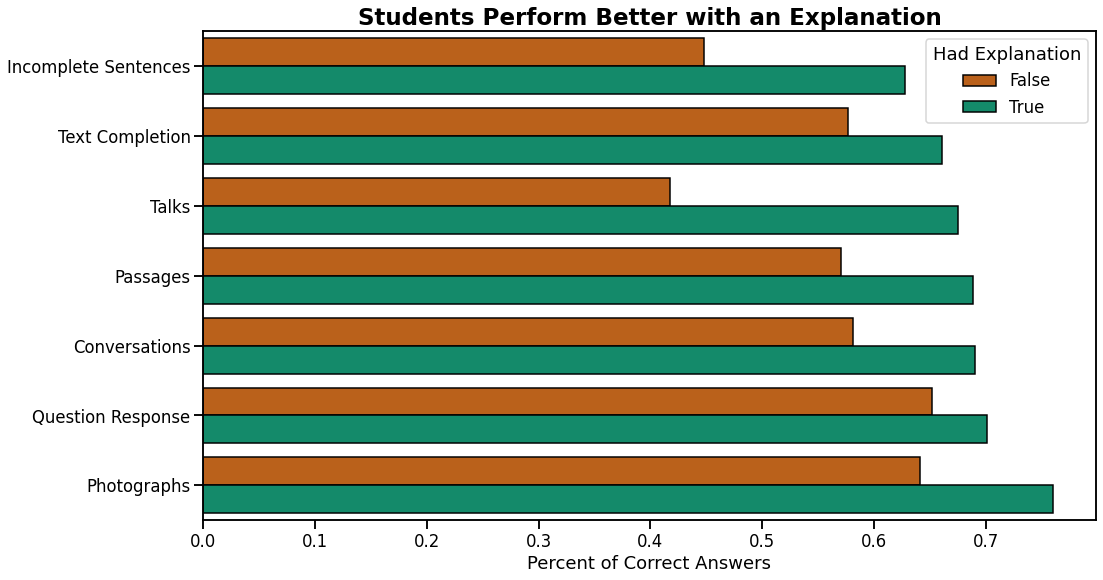

In [29]:
sns.set_context('talk')

plt.figure(figsize=(16, 9))
sns.barplot(data=part_explanation_acc, x='answered_correctly', y='part', hue="question_had_explanation", 
            palette=['#d55e00', '#009e73'], ec='black')
plt.xlabel("Percent of Correct Answers")
plt.legend(bbox_to_anchor=(1, 1), title ='Had Explanation')
plt.title("Students Perform Better with an Explanation",fontweight='bold', fontsize=23)
plt.ylabel("")
plt.show()

### How does explanation affect Reading vs. Listening sections?

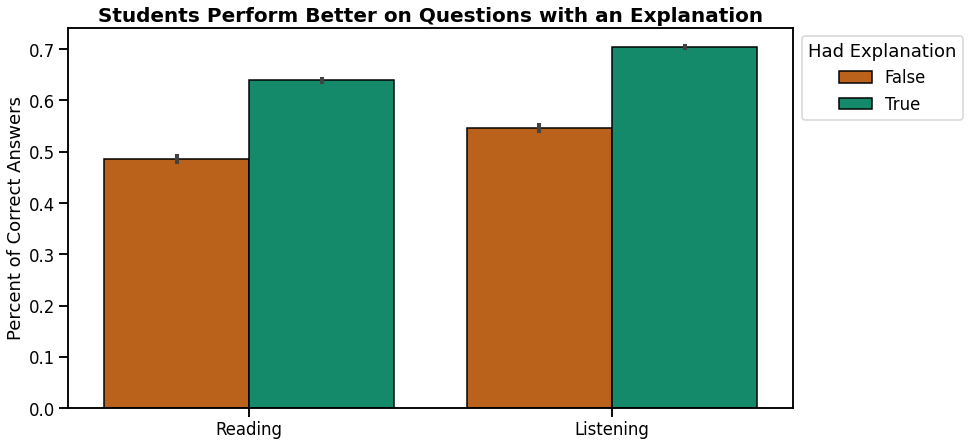

In [28]:
sns.set_context('talk')

plt.figure(figsize=(13,7))
sns.barplot(data=train, x='sections', y='answered_correctly', hue='question_had_explanation',
            palette=['#d55e00', '#009e73'], ec='black')
plt.title("Students Perform Better on Questions with an Explanation", fontweight='bold', fontsize=20)
plt.xlabel("")
plt.ylabel("Percent of Correct Answers")
plt.legend(bbox_to_anchor=(1, 1), title ='Had Explanation')
plt.show()

### Question to answer: Do the students watching more lectures perform better?

In [31]:
# Find the how many lectures in total a user has watched
user_lectures = train.groupby('user_id').user_lectures_running_total.max().sort_values(ascending=False)

# Convert it to dataframe
user_lectures = pd.DataFrame(user_lectures)

# Give the column an self-explanatory name
user_lectures.rename(columns={'user_lectures_running_total': 'total_lectures_user_watched'}, inplace=True)

# Double check if the column is successfully created
user_lectures.head()

,total_lectures_user_watched
user_id,
1991343787,250
856894755,203
2042598372,200
634707013,185
1818053521,176


In [32]:
# Compute the average accuracy of a user when answering question

user_acc_mean = train.groupby('user_id').user_acc_mean.mean().sort_values(ascending=False)
user_acc_mean.head()

user_id
948981228     1.000000
587629436     0.958333
1664729180    0.958333
740684598     0.958333
1419533433    0.937500
Name: user_acc_mean, dtype: float64

In [33]:
# Join the two dataframes

user_lectures_accu = user_lectures.merge(user_acc_mean, how='left', on="user_id")
user_lectures_accu.head()

,total_lectures_user_watched,user_acc_mean
user_id,,
1991343787,250,0.625825
856894755,203,0.609221
2042598372,200,0.651562
634707013,185,0.514623
1818053521,176,0.569497


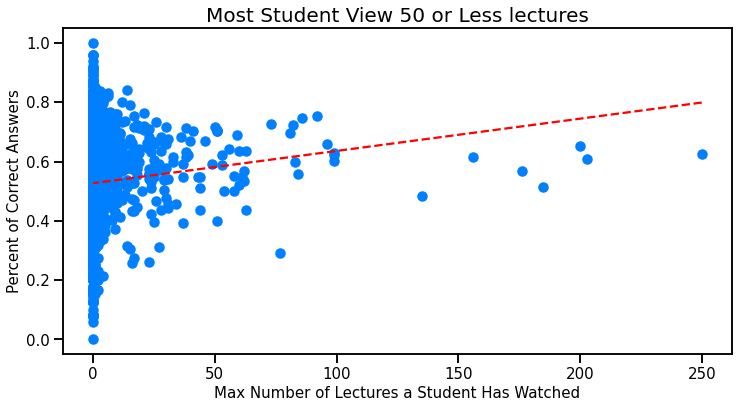

In [44]:
# Plot the average accuracy of a user again the lectures the user has watched in total

fig = plt.figure(figsize=(12,6))
x = user_lectures_accu.total_lectures_user_watched
y = user_lectures_accu.user_acc_mean
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Most Student View 50 or Less lectures", fontsize=20)
plt.xlabel("Max Number of Lectures a Student Has Watched", fontsize=15)
plt.ylabel("Percent of Correct Answers", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [40]:
# Compute the users' cumulative accuracy over time

# Generate the all the unique user ids in the train dataset
user_ids = train.user_id.unique()

# Create an empty dataset to hold the values of cumulative accuracy
data = pd.DataFrame(columns = ['cum_accuracy'])

# For loop through all the users to compute their cumulative accuracy over time
for user in user_ids:
    mask = train.user_id == user
    df = train[mask]
    n = df.shape[0]
    user_cumacc = pd.DataFrame(df.answered_correctly.cumsum())
    user_cumacc['num_question'] = range(1, n+1)
    user_cumacc['cum_accuracy'] = user_cumacc.answered_correctly/user_cumacc.num_question
    data = data.append(user_cumacc)

In [41]:
# Create a variable to hold the values of cumulative accuracy
cum_acc = data[['cum_accuracy']]
cum_acc.head()

,cum_accuracy
0,1.000000
1,0.500000
2,0.666667
3,0.750000
4,0.600000


In [42]:
# Concat the cumulative accuracy to the train dataset
train = pd.concat([train, cum_acc], axis=1)
train.head(2)

,timestamp,user_id,content_id,task_container_id,answered_correctly,question_had_explanation,user_acc_mean,user_lectures_running_total,q_time,avg_user_q_time,...,mean_bundle_accuracy,mean_part_accuracy,mean_container_part_accuracy,mean_content_accuracy,mean_task_accuracy,mean_tagcount_accuracy,mean_tags_accuracy,sections,is_incomplete_sentence_part,cum_accuracy
0,0,1864702,5720,0,1,False,0.630049,0,45951.0,11917302.0,...,0.82,0.61,1.0,0.82,0.68,0.62,0.79,Reading,incomplete sentences,1.0
1,45951,1864702,5204,1,0,False,0.630049,0,28391.0,11917302.0,...,0.55,0.61,0.0,0.55,0.53,0.62,0.65,Reading,incomplete sentences,0.5


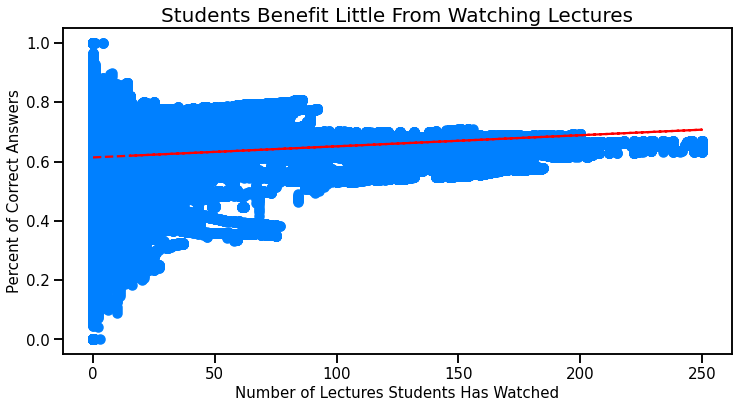

In [46]:
# Plot the cumulative accuracy against the lectures the user has watched

fig = plt.figure(figsize=(12,6))
x = train.user_lectures_running_total
y = train.cum_accuracy
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Students Benefit Little From Watching Lectures", fontsize=20)
plt.xlabel("Number of Lectures Students Has Watched", fontsize=15)
plt.ylabel("Percent of Correct Answers", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [55]:
# Compute the mean of the lectures students has watched
# Compute the mean of the accuracy

print("The mean of the lectures students has watched: ", train.user_lectures_running_total.mean())
print("The mean of accuracy: ", train.cum_accuracy.mean())

The mean of the lectures students has watched:  24.149346640983495
The mean of accuracy:  0.6230327417336106


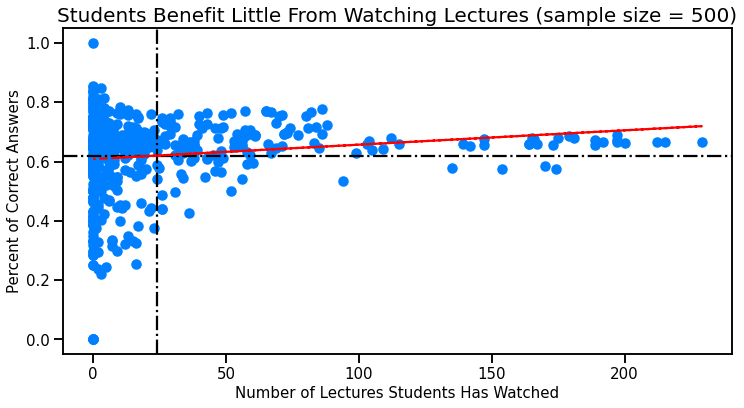

In [72]:
# Plot the cumulative accuracy against the lectures the user has watched

fig = plt.figure(figsize=(12,6))
sample = train.sample(500)
x = sample.user_lectures_running_total
y = sample.cum_accuracy
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Students Benefit Little From Watching Lectures (sample size = 500)", fontsize=20)
plt.xlabel("Number of Lectures Students Has Watched", fontsize=15)
plt.ylabel("Percent of Correct Answers", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.axhline(0.62, xmin=0, xmax=250, color='black', linestyle='-.')
plt.axvline(24.1, ymin=0, ymax=1.0, color='black', linestyle='-.')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

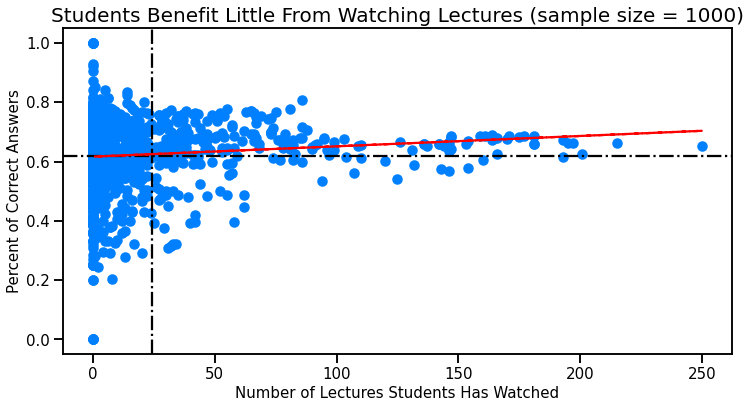

In [73]:
# Plot the cumulative accuracy against the lectures the user has watched

fig = plt.figure(figsize=(12,6))
sample = train.sample(1000)
x = sample.user_lectures_running_total
y = sample.cum_accuracy
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Students Benefit Little From Watching Lectures (sample size = 1000)", fontsize=20)
plt.xlabel("Number of Lectures Students Has Watched", fontsize=15)
plt.ylabel("Percent of Correct Answers", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.axhline(0.62, xmin=0, xmax=250, color='black', linestyle='-.')
plt.axvline(24.1, ymin=0, ymax=1.0, color='black', linestyle='-.')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

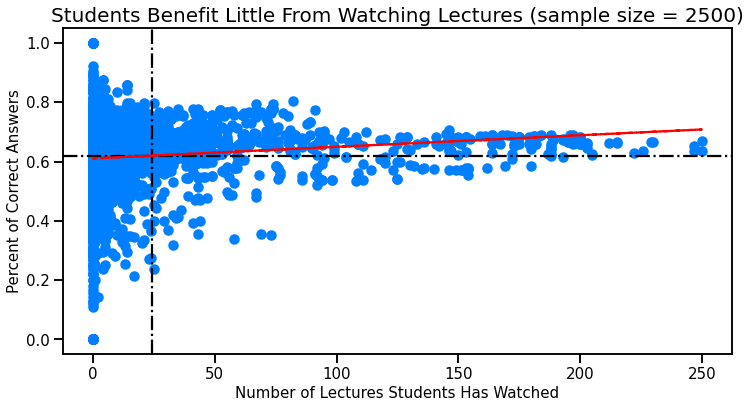

In [74]:
# Plot the cumulative accuracy against the lectures the user has watched

fig = plt.figure(figsize=(12,6))
sample = train.sample(2500)
x = sample.user_lectures_running_total
y = sample.cum_accuracy
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Students Benefit Little From Watching Lectures (sample size = 2500)", fontsize=20)
plt.xlabel("Number of Lectures Students Has Watched", fontsize=15)
plt.ylabel("Percent of Correct Answers", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.axhline(0.62, xmin=0, xmax=250, color='black', linestyle='-.')
plt.axvline(24.1, ymin=0, ymax=1.0, color='black', linestyle='-.')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

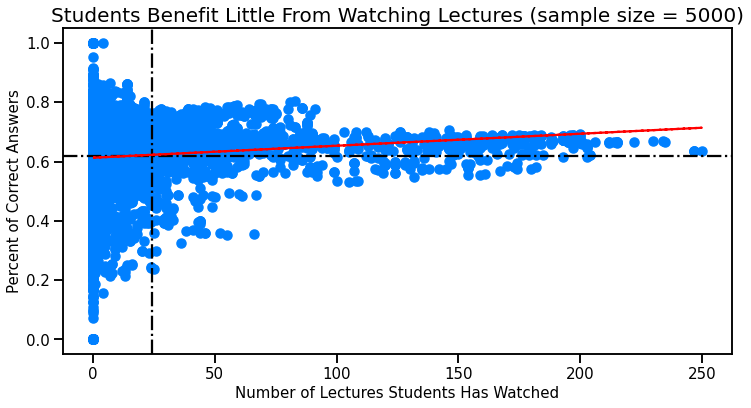

In [75]:
# Plot the cumulative accuracy against the lectures the user has watched

fig = plt.figure(figsize=(12,6))
sample = train.sample(5000)
x = sample.user_lectures_running_total
y = sample.cum_accuracy
plt.scatter(x, y, marker='o',color='#0080ff')
plt.title("Students Benefit Little From Watching Lectures (sample size = 5000)", fontsize=20)
plt.xlabel("Number of Lectures Students Has Watched", fontsize=15)
plt.ylabel("Percent of Correct Answers", fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.axhline(0.62, xmin=0, xmax=250, color='black', linestyle='-.')
plt.axvline(24.1, ymin=0, ymax=1.0, color='black', linestyle='-.')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

### Seperate the features and target
- For feature selction
- For modeling

In [6]:
X_train = train_s.drop(columns='answered_correctly')
y_train = train_s['answered_correctly']

X_validate = validate_s.drop(columns='answered_correctly')
y_validate = validate_s['answered_correctly']

X_test = test_s.drop(columns='answered_correctly')
y_test = test_s['answered_correctly']

### SelectKBest

In [7]:
# Use the helper function in explore.py to rank all the features

explore.KBest_ranker(X_train, y_train, 10)

,features,score,rank
0,mean_content_accuracy,76670.58,1
1,mean_bundle_accuracy,55971.00,2
2,user_acc_mean,22419.10,3
3,mean_tags_accuracy,21599.32,4
4,mean_task_accuracy,15894.15,5
5,question_had_explanation,3954.75,6
6,mean_part_accuracy,3397.75,7
7,mean_tagcount_accuracy,2389.41,8
8,user_lectures_running_total_scaled,211.82,9
9,avg_user_q_time_scaled,116.95,10


### Modeling - Compute the baseline

### Use the randomly generated classes as the baseline

In [8]:
# Create the y_predicted on y_train

size = y_train.size
print("The size of y_train is: ", size)
y_train.head()

The size of y_train is:  403377


0    1
1    0
2    1
3    1
4    0
Name: answered_correctly, dtype: int64

In [9]:
# Create the baseline using randomly generated [0,1]

y_baseline_r = np.random.randint(2, size=size)
y_baseline_r[:5]

array([0, 1, 0, 0, 1])

In [10]:
# Compute its AUC score
roc_auc_score(y_train, y_baseline_r)

0.5010486273281269

### Use the most frequent class as the baseline

In [11]:
# Find out the most frequent class
y_train.value_counts(normalize=True)

1    0.650932
0    0.349068
Name: answered_correctly, dtype: float64

In [12]:
# Compute the basedline using the most frequent class

y_baseline_mf = np.array([1]*size)
y_baseline_mf

array([1, 1, 1, ..., 1, 1, 1])

In [13]:
# Compute its AUC score
roc_auc_score(y_train, y_baseline_mf)

0.5

### Binary classification modeling
- 'LogisticRegression'
- 'Decision Tree'
- 'Random Forest'
- 'Ada Boost'
- 'Gradient Boost'
- 'Nearest Neighbors'
- 'Naive Bayes'
- 'Neural Net'

In [14]:
# Defind the fucntion to compute the auc score 
# on given classifiers,features dataset (X) and target variable (y)

def auc_score_proba(clf, X, y):
    '''
    This function accepts a classification model that can estimate probability, X_set and y_set
    and returns a dataframe of predicted probabilty on a binary class
    and also returns a auc score
    
    Parameter
    ----------
    clf: the classification algorithm after fitting with X_train, y_train
    X: X_train, X_validate and X_test
    y: y_train, y_validate and y_test
    
    Returns
    ----------
    1. A dataframe containing the probability estimates
    2. AUC score
    '''
    y_proba = clf.predict_proba(X)
    y_proba = pd.DataFrame(y_proba, columns=['p_0', 'p_1'])
    score = roc_auc_score(y, y_proba['p_1'])
    return y_proba, score

In [15]:
# Define a function to go through a list of classifiers 
# to model on train/validate/test

def model_multiple_algos(names, classifiers, X_train, y_train, X_validate, y_validate, X_test, y_test):
    
    metrics = pd.DataFrame()

    for name, clf in zip(names, classifiers):
        
        # Set up a progress indicator        
        print(f"Currently runnig on model {name}")
        
        # Working on thr train dataset        
        clf = clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_train)
        y_proba, score = auc_score_proba(clf, X_train, y_train)
        d = {"Algo": name, "dataset": "train", "AUC score": score}
        metrics = metrics.append(d, ignore_index=True)
        
        # Working on the validate dataset
        y_proba, score = auc_score_proba(clf, X_validate, y_validate)
        d = {"Algo": name, "dataset": "validate", "AUC score": score}
        metrics = metrics.append(d, ignore_index=True)
             
        # Working on the test dataset
        y_proba, score = auc_score_proba(clf, X_test, y_test)
        d = {"Algo": name, "dataset": "test", "AUC score": score}
        metrics = metrics.append(d, ignore_index=True)
             
    return metrics

In [45]:
# Create a list of names of the classifiers

names = ['LogisticRegression', # predict_proba: yes
         'Decision Tree', # predict_proba: yes
         'Random Forest', # predict_proba: yes
         'Ada Boost', # predict_proba: yes
         'Gradient Boost', # predict_proba: yes
         'Nearest Neighbors', # predict_proba: yes
         'Naive Bayes', # predict_proba: yes
         'Neural Net' # predict_proba: yes
        ]

In [46]:
# Create a list of classifiers

classifiers = [LogisticRegression(), 
               DecisionTreeClassifier(max_depth=3),
               RandomForestClassifier(max_depth=3),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               KNeighborsClassifier(3),
               GaussianNB(), 
               MLPClassifier()
              ]

In [47]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [48]:
# Modeling using the list of algorithms defined above

metrics = model_multiple_algos(names, classifiers, 
                               X_train, y_train, 
                               X_validate, y_validate, 
                               X_test, y_test)

Currently runnig on model LogisticRegression
Currently runnig on model Decision Tree
Currently runnig on model Random Forest
Currently runnig on model Ada Boost
Currently runnig on model Gradient Boost
Currently runnig on model Nearest Neighbors
Currently runnig on model Naive Bayes
Currently runnig on model Neural Net


In [50]:
# Firstly, create a mask for the test
mask = metrics.dataset == "test"

# Rank auc score on test in a descending order
metrics[mask].sort_values(by="AUC score", ascending=False)

,AUC score,Algo,dataset
8,0.692875,Random Forest,test
2,0.691238,LogisticRegression,test
23,0.690661,Neural Net,test
14,0.686273,Gradient Boost,test
11,0.678628,Ada Boost,test
20,0.676666,Naive Bayes,test
5,0.675218,Decision Tree,test
17,0.626234,Nearest Neighbors,test


### Binary Classification Modeling
- LightGBM

[LightGBM] [Info] Number of positive: 262571, number of negative: 140806
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 403377, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650932 -> initscore=0.623138
[LightGBM] [Info] Start training from score 0.623138
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.586192
0.7031589183255875


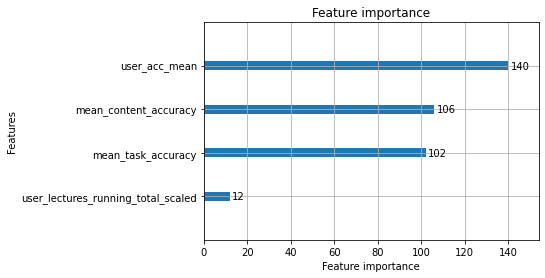

In [16]:
# Create the LightGBM data containers on train and validate
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=[0])
validate_data = lgb.Dataset(X_validate, label=y_validate)

parameters = {
    'application': 'binary'
}

# Predict on validate
model = lgb.train(parameters,
                  train_data,
                  valid_sets=validate_data,
                  verbose_eval=100,
                  num_boost_round=10000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_validate)

print(roc_auc_score(y_validate, y_pred))
lgb.plot_importance(model)
plt.show()

[LightGBM] [Info] Number of positive: 262571, number of negative: 140806
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1116
[LightGBM] [Info] Number of data points in the train set: 403377, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650932 -> initscore=0.623138
[LightGBM] [Info] Start training from score 0.623138
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.601501
0.691478150332094


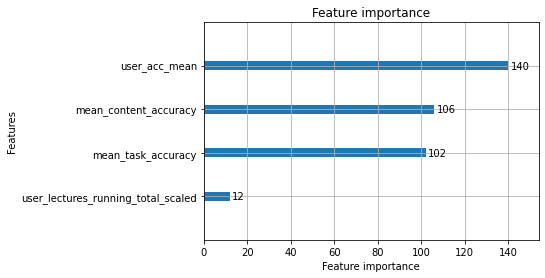

In [17]:
# Create the LightGBM data containers on train and test
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=[0])
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary'
}

# Predict on test
model = lgb.train(parameters,
                  train_data,
                  valid_sets=test_data,
                  verbose_eval=100,
                  num_boost_round=10000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test)

print(roc_auc_score(y_test, y_pred))
lgb.plot_importance(model)
plt.show()

In [58]:
# Define the function to plot the ROC curve

def auc_curve_plot1(clf, algo_name, X, y):
    '''
    This function accepts y_validate or y_test and predict_proba or decision_function classifier attribute
    Example:
    ---------
    auc_mertic(actual_outcome=y_validate, decision_func=svc.decision_function(X_validate))
    Returns a plot of the ROC curve.
    Parameters
    ----------
    clf : The classification model fit with X_train, y_train
    X : X_validate or X_test
    y : y_validate or y_test
    Returns
    -------
    A visualization of the roc for a given classification model.
    '''
    # Set visualization defaults
    sns.set_context('talk')
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the roc curve
    plot_roc_curve(clf, X, y, ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    ax.set_title(f"ROC curve for {algo_name}")
    
    plt.legend()
    plt.tight_layout()
    plt.show()